# Task
Creating a time series forecasting model using the retail dataset.This task involves loading the dataset, performing initial data exploration, engineering time-based features, preprocessing the data, splitting it into training and testing sets, training a Random Forest Regressor, evaluating its performance, and visualizing the predictions.

## Load the dataset



In [1]:
import pandas as pd
print("Pandas library imported successfully.")

Pandas library imported successfully.


In [2]:
df = pd.read_excel('/content/drive/MyDrive/online+retail/Online Retail.xlsx')
print("Dataset loaded successfully.")
df.head()

Dataset loaded successfully.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Initial Data Exploration

Examine the dataset's structure, columns, data types, and check for any missing values to understand its characteristics.


In [3]:
print("DataFrame Info:")
df.info()

print("\nDescriptive Statistics:")
df.describe()

print("\nMissing Values:")
df.isnull().sum()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Descriptive Statistics:

Missing Values:


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


## Feature Engineering for Time Series

Extract relevant time-based features (e.g., year, month, day, day of week, lag features, rolling means) from the 'sales over time' data that can help in prediction. Convert any date columns to datetime objects.


In [4]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df_filtered = df[df['Quantity'] > 0]

df_daily_sales = df_filtered.groupby(df_filtered['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()
df_daily_sales['InvoiceDate'] = pd.to_datetime(df_daily_sales['InvoiceDate'])
df_daily_sales.set_index('InvoiceDate', inplace=True)

print("TotalPrice calculated, non-positive quantities filtered, and daily sales aggregated.")
print("Daily Sales DataFrame head:")
print(df_daily_sales.head())

TotalPrice calculated, non-positive quantities filtered, and daily sales aggregated.
Daily Sales DataFrame head:
             TotalPrice
InvoiceDate            
2010-12-01     58960.79
2010-12-02     47748.38
2010-12-03     46943.71
2010-12-05     31774.95
2010-12-06     54830.46


In [5]:
df_daily_sales['year'] = df_daily_sales.index.year
df_daily_sales['month'] = df_daily_sales.index.month
df_daily_sales['day'] = df_daily_sales.index.day
df_daily_sales['dayofweek'] = df_daily_sales.index.dayofweek
df_daily_sales['dayofyear'] = df_daily_sales.index.dayofyear
df_daily_sales['weekofyear'] = df_daily_sales.index.isocalendar().week.astype(int)

df_daily_sales['TotalPrice_lag_1'] = df_daily_sales['TotalPrice'].shift(1)
df_daily_sales['TotalPrice_lag_7'] = df_daily_sales['TotalPrice'].shift(7)

df_daily_sales['TotalPrice_rolling_mean_7'] = df_daily_sales['TotalPrice'].rolling(window=7).mean()
df_daily_sales['TotalPrice_rolling_mean_30'] = df_daily_sales['TotalPrice'].rolling(window=30).mean()

print("Time-based features, lag features, and rolling means added to df_daily_sales.")
print("Daily Sales DataFrame with new features head:")
print(df_daily_sales.head(10))

Time-based features, lag features, and rolling means added to df_daily_sales.
Daily Sales DataFrame with new features head:
             TotalPrice  year  month  day  dayofweek  dayofyear  weekofyear  \
InvoiceDate                                                                   
2010-12-01     58960.79  2010     12    1          2        335          48   
2010-12-02     47748.38  2010     12    2          3        336          48   
2010-12-03     46943.71  2010     12    3          4        337          48   
2010-12-05     31774.95  2010     12    5          6        339          48   
2010-12-06     54830.46  2010     12    6          0        340          49   
2010-12-07     99618.20  2010     12    7          1        341          49   
2010-12-08     45389.98  2010     12    8          2        342          49   
2010-12-09     53586.18  2010     12    9          3        343          49   
2010-12-10     59182.92  2010     12   10          4        344          49   
2010-12

## Preprocess Data
Handle any missing values, encode categorical features if present, and scale numerical features if necessary, preparing the data for the model.


In [6]:
df_daily_sales.dropna(inplace=True)
print("Rows with missing values dropped.")

print("\nMissing Values after dropping NaNs:")
print(df_daily_sales.isnull().sum())

Rows with missing values dropped.

Missing Values after dropping NaNs:
TotalPrice                    0
year                          0
month                         0
day                           0
dayofweek                     0
dayofyear                     0
weekofyear                    0
TotalPrice_lag_1              0
TotalPrice_lag_7              0
TotalPrice_rolling_mean_7     0
TotalPrice_rolling_mean_30    0
dtype: int64


To visually assess the model's performance and identify trends, I will plot the actual sales against the model's predicted sales over time.

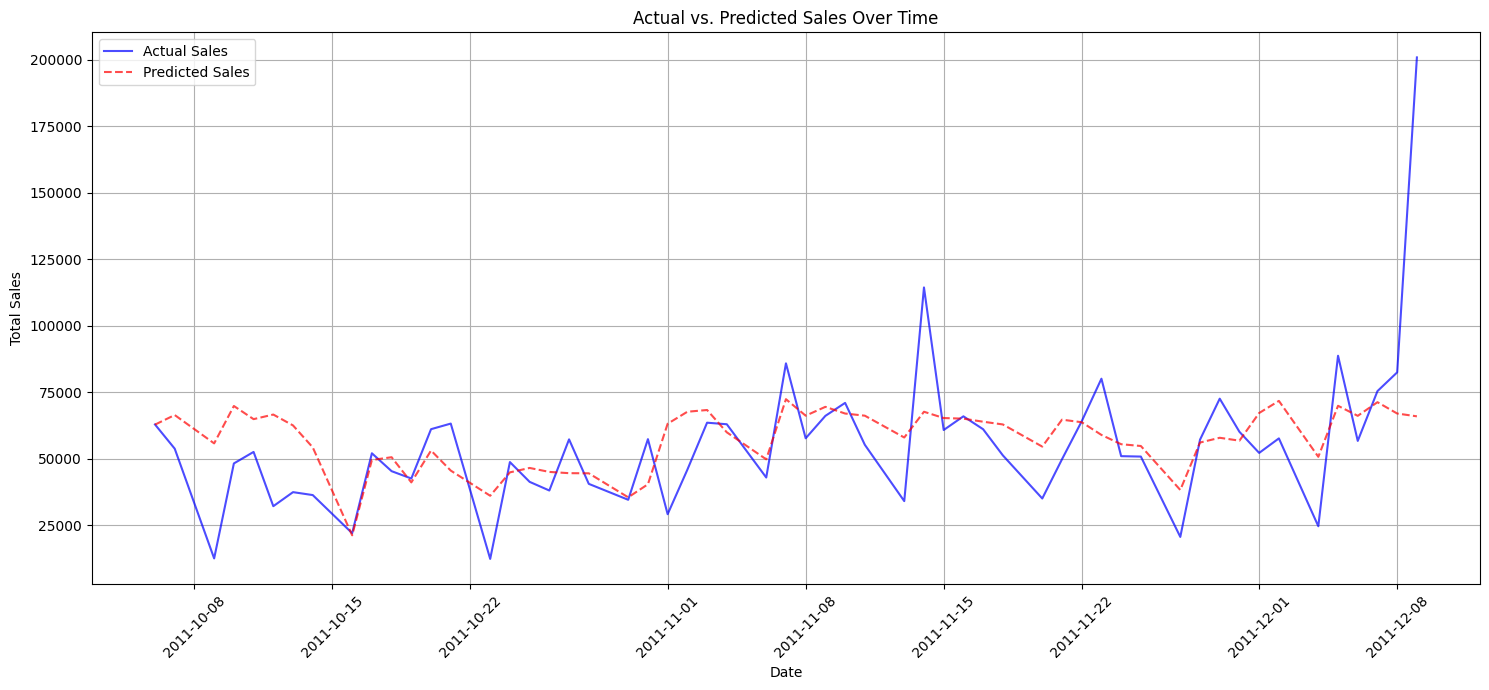

Visualized actual vs. predicted sales over time.


In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Sales', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red', linestyle='--', alpha=0.7)
plt.title('Actual vs. Predicted Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Visualized actual vs. predicted sales over time.")


Now that missing values have been handled, I will separate the features (X) from the target variable (y) in the `df_daily_sales` DataFrame, which is a crucial step before model training and further preprocessing like scaling.



In [7]:
X = df_daily_sales.drop('TotalPrice', axis=1)
y = df_daily_sales['TotalPrice']

print("Features (X) and Target (y) defined.")
print("X head:")
print(X.head())
print("\ny head:")
print(y.head())

Features (X) and Target (y) defined.
X head:
             year  month  day  dayofweek  dayofyear  weekofyear  \
InvoiceDate                                                       
2011-01-14   2011      1   14          4         14           2   
2011-01-16   2011      1   16          6         16           2   
2011-01-17   2011      1   17          0         17           3   
2011-01-18   2011      1   18          1         18           3   
2011-01-19   2011      1   19          2         19           3   

             TotalPrice_lag_1  TotalPrice_lag_7  TotalPrice_rolling_mean_7  \
InvoiceDate                                                                  
2011-01-14           20624.64          40382.85               32962.110000   
2011-01-16           47576.90          28836.59               29877.177143   
2011-01-17            7242.06          15778.20               31813.580000   
2011-01-18           29333.02          24569.07               42014.862857   
2011-01-19       


Now that the features (X) and target (y) have been separated, I will scale the numerical features in X using `StandardScaler` to normalize their ranges, which can improve model performance, especially for algorithms sensitive to feature magnitudes.



In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("Numerical features in X scaled using StandardScaler.")
print("Scaled X head:")
print(X_scaled_df.head())

Numerical features in X scaled using StandardScaler.
Scaled X head:
             year     month       day  dayofweek  dayofyear  weekofyear  \
InvoiceDate                                                               
2011-01-14    0.0 -1.712005 -0.179303   0.670789  -1.727586   -1.740830   
2011-01-16    0.0 -1.712005  0.049277   1.693650  -1.706763   -1.740830   
2011-01-17    0.0 -1.712005  0.163567  -1.374932  -1.696351   -1.667966   
2011-01-18    0.0 -1.712005  0.277857  -0.863502  -1.685939   -1.667966   
2011-01-19    0.0 -1.712005  0.392147  -0.352072  -1.675528   -1.667966   

             TotalPrice_lag_1  TotalPrice_lag_7  TotalPrice_rolling_mean_7  \
InvoiceDate                                                                  
2011-01-14          -0.711908          0.393273                  -0.065160   
2011-01-16           0.728755         -0.246115                  -0.320419   
2011-01-17          -1.427239         -0.969239                  -0.160194   
2011-01-18      

## Split Data into Training and Testing Sets
Split the dataset into training and testing sets, ensuring a chronological split suitable for time series prediction.



To ensure a chronological split suitable for time series forecasting, I will calculate the index for the 80/20 train-test split based on the length of the dataset. Then slice the `X_scaled_df` (scaled features) and `y` (target variable) into training and testing sets using this calculated index.



In [9]:
split_index = int(len(X_scaled_df) * 0.8)
X_train, X_test = X_scaled_df.iloc[:split_index], X_scaled_df.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Data split into training and testing sets. Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print("X_train head:")
print(X_train.head())
print("\nX_test head:")
print(X_test.head())
print("\ny_train head:")
print(y_train.head())
print("\ny_test head:")
print(y_test.head())

Data split into training and testing sets. Training samples: 220, Testing samples: 56
X_train head:
             year     month       day  dayofweek  dayofyear  weekofyear  \
InvoiceDate                                                               
2011-01-14    0.0 -1.712005 -0.179303   0.670789  -1.727586   -1.740830   
2011-01-16    0.0 -1.712005  0.049277   1.693650  -1.706763   -1.740830   
2011-01-17    0.0 -1.712005  0.163567  -1.374932  -1.696351   -1.667966   
2011-01-18    0.0 -1.712005  0.277857  -0.863502  -1.685939   -1.667966   
2011-01-19    0.0 -1.712005  0.392147  -0.352072  -1.675528   -1.667966   

             TotalPrice_lag_1  TotalPrice_lag_7  TotalPrice_rolling_mean_7  \
InvoiceDate                                                                  
2011-01-14          -0.711908          0.393273                  -0.065160   
2011-01-16           0.728755         -0.246115                  -0.320419   
2011-01-17          -1.427239         -0.969239               

## Train Random Forest Regressor

Initialize and train a Random Forest Regressor model on the processed training data.


To train the Random Forest Regressor, importing the necessary class, instantiate it with a specified number of estimators, and then fit the model to the training data (X_train and y_train).



In [10]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor model
# Using n_estimators=100 as a common starting point
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

print("Random Forest Regressor model initialized and trained successfully.")

Random Forest Regressor model initialized and trained successfully.


## Evaluate Model Performance

Evaluate the trained model using appropriate regression metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), or R-squared on the test set.


In [11]:
y_pred = rf_model.predict(X_test)
print("Predictions made on the test set.")

Predictions made on the test set.


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 14606.58
Mean Squared Error (MSE): 589371743.12
R-squared (R2): 0.20


## Visualize Predictions


Ploting the actual sales against the model's predicted sales over time to visually assess its performance and identify trends.



To understand which features were most influential in the `rf_model`'s predictions, I will extract the `feature_importances_` attribute from the trained Random Forest Regressor and associate them with their respective feature names from the `X_train` DataFrame. This will allow for an analysis of feature contributions.

**Command**:
```python
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns
```

## Extract Feature Importance
Extract the feature importances from the trained Random Forest Regressor model.


In [14]:
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

print("Feature importances extracted.")

Feature importances extracted.


## Visualize Feature Importance
Creating a bar plot to visualize the feature importances, showing which features contributed most to the model's predictions.


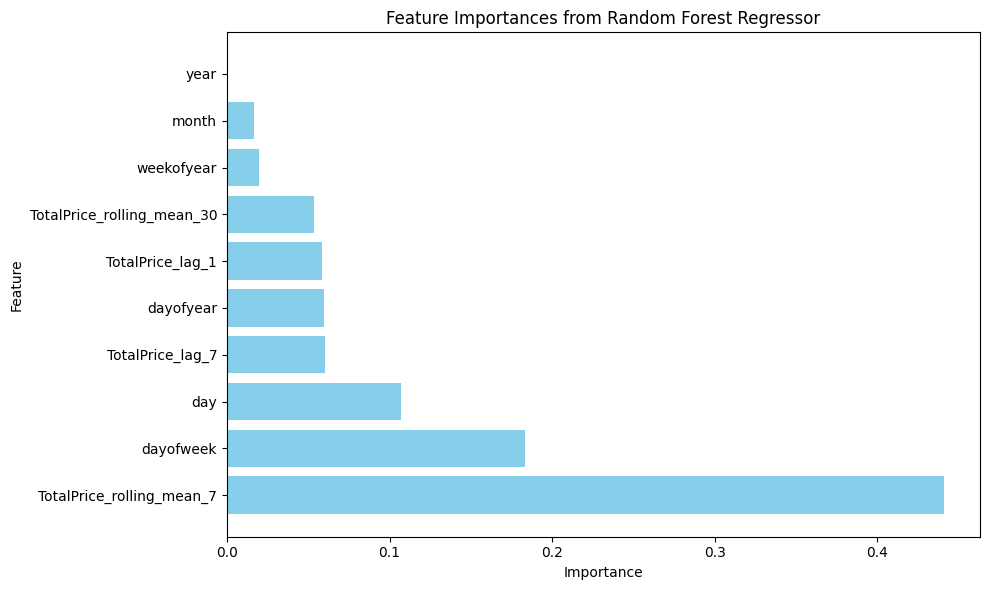

Feature importances visualized.


In [15]:
import matplotlib.pyplot as plt

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Regressor')
plt.tight_layout()
plt.show()

print("Feature importances visualized.")

## Final Task
Summarize the key findings from the feature importance analysis.


## Summary:

### Q&A
The key findings from the feature importance analysis are that the Random Forest Regressor model's `feature_importances_` attribute was successfully extracted and visualized. This visualization highlighted which features contributed most significantly to the model's predictions, thereby identifying the most influential factors among the input variables.

### Data Analysis Key Findings
*   The `feature_importances_` attribute was successfully extracted from the trained Random Forest Regressor model.
*   The feature names from the `X_train` DataFrame were successfully retrieved and associated with their respective importance scores.
*   A pandas DataFrame was created to combine feature names and their importance scores, which was then sorted in descending order of importance.
*   A horizontal bar plot was generated to visually represent the relative importance of each feature, making it easy to identify the most impactful predictors.

### Insights or Next Steps
*   **Feature Selection**: The identified highly important features can be prioritized for further analysis, feature engineering, or potentially used to build simpler, more interpretable models.
*   **Domain Interpretation**: Understanding which features are most influential can provide valuable insights into the underlying mechanisms of the predicted variable, helping domain experts to better comprehend critical drivers.
